# System Model V3 - Shock test

The purpose of this notebook is to perform shocks of ETH price to test controller parameter stability, without stochastic processes.

For this simulation run, we will be asking the following question: how does the model behave with a eth price shock?

Run simulation with overrides over the default values:
* 'controller_enabled': [True],
* 'liquidation_ratio': [1.45],
* 'interest_rate': [1.03],
* 'liquidity_demand_enabled': [False],
* 'arbitrageur_considers_liquidation_ratio': [True],
* 'liquidity_demand_shock': [False],
*'eth_price': [lambda run, timestep, df=None: [
        # Shocks at 14 days; controller turns on at 7 days
        300,
        300 if timestep < 24 * 14 else 300 * 1.3, # 30% step, remains for rest of simulation
        300 * 1.3 if timestep in list(range(24*14, 24*14 + 6, 1)) else 300, # 30% impulse for 6 hours
        300 if timestep < 24 * 14 else 300 * 0.7, # negative 30% step, remains for rest of simulation
        300 * 0.7 if timestep in list(range(24*14, 24*14 + 6, 1)) else 300, # negative 30% impulse for 6 hours
    ][run - 1]],
* 'liquidity_demand_events': [lambda run, timestep, df=None: 0],
* 'token_swap_events': [lambda run, timestep, df=None: 0],
}

In order to test this, configure the following experiment [experiment_shocks.py](experiments/system_model_v3/experiment_shocks.py). Run run this simulation, we create a directory in the ```experiments/system_model_v3``` called ```experiment_shocks/```,and add a ```logs/``` directory inside of it.

Assuming our we have all of the requirements required (run requirements.txt from the ```reflexer/``` root directory to be sure. Assuming our terminal is in the root directory, we run the follow to run the simulation:

```bash
python3 -m experiments.system_model_v3.experiment_shocks
```
And our simulation will run. The resulting [run log](experiments/system_model_v3/experiment_shocks/experiment_run_log.md) can be found in the ```experiments/system_model_v3/experiment_shocks/``` directory, along with the simulation results stored as ```experiment_results.hdf5```


Below we will import and examine the simulation results.


In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

## Import simulation run data


In [2]:
os.getcwd()

'/home/aclarkdata/repos/reflexer/notebooks/analysis'

In [3]:
os.chdir('../../')
os.getcwd()

'/home/aclarkdata/repos/reflexer'

In [4]:
experiment_results = 'experiments/system_model_v3/experiment_shocks/experiment_results.hdf5'
experiment_results_keys = []
with pd.HDFStore(experiment_results) as store:
    experiment_results_keys = list(filter(lambda x: "results" in x, store.keys()))
    exceptions_keys = list(filter(lambda x: "exceptions" in x, store.keys()))

In [5]:
# A list of all experiment result keys
experiment_results_keys

['/results_2021-03-04T09:46:21.528200', '/results_2021-03-11T13:11:13.823533']

In [6]:
# Copy a results_ key from the above keys to select the experiment
experiment_results_key = experiment_results_keys[-1]
experiment_timestamp = experiment_results_key.strip('results_')
exceptions_key = 'exceptions_' + experiment_timestamp
experiment_timestamp

'/results_2021-03-11T13:11:13.823533'

In [7]:
df_raw = pd.read_hdf(experiment_results, experiment_results_key)
df_raw.tail()

,cdp_metrics,optimal_values,sim_metrics,timedelta,cumulative_time,timestamp,blockheight,eth_price,liquidity_demand,liquidity_demand_mean,...,RAI_balance,ETH_balance,UNI_supply,uniswap_oracle,simulation,subset,run,substep,timestep,events
7200,"{'cdp_count': 1, 'open_cdp_count': 1, 'closed_...",{},{},3600,5169600,2017-03-01 20:00:00,0,300.0,0,0.0,...,6.965043e+06,154081.310382,10000000.0,None,0,0,5,18,1436,NaN
7201,"{'cdp_count': 1, 'open_cdp_count': 1, 'closed_...",{},{},3600,5173200,2017-03-01 21:00:00,0,300.0,0,0.0,...,6.964866e+06,154085.255466,10000000.0,None,0,0,5,18,1437,NaN
7202,"{'cdp_count': 1, 'open_cdp_count': 1, 'closed_...",{},{},3600,5176800,2017-03-01 22:00:00,0,300.0,0,0.0,...,6.964688e+06,154089.200651,10000000.0,None,0,0,5,18,1438,NaN
7203,"{'cdp_count': 1, 'open_cdp_count': 1, 'closed_...",{},{},3600,5180400,2017-03-01 23:00:00,0,300.0,0,0.0,...,6.964510e+06,154093.145937,10000000.0,<models.system_model_v3.model.parts.uniswap_or...,0,0,5,18,1439,NaN
7204,"{'cdp_count': 1, 'open_cdp_count': 1, 'closed_...",{},{},3600,5184000,2017-03-02 00:00:00,0,300.0,0,0.0,...,6.964332e+06,154097.091324,10000000.0,<models.system_model_v3.model.parts.uniswap_or...,0,0,5,18,1440,NaN


## Post process


In [8]:
from experiments.system_model_v3.post_process import post_process_results
from experiments.system_model_v3.experiment_shocks import params, SIMULATION_TIMESTEPS

In [9]:
params

{'debug': [False],
 'raise_on_assert': [True],
 'free_memory_states': [['events', 'cdps', 'uniswap_oracle']],
 'IntegralType': [2],
 'eth_price': [<function experiments.system_model_v3.experiment_shocks.<lambda>(run, timestep, df=None)>],
 'liquidity_demand_events': [<function experiments.system_model_v3.experiment_shocks.<lambda>(run, timestep, df=None)>],
 'token_swap_events': [<function experiments.system_model_v3.experiment_shocks.<lambda>(run, timestep, df=None)>],
 'seconds_passed': [<function models.system_model_v3.model.params.init.<lambda>(timestep, df=None)>],
 'liquidity_demand_enabled': [False],
 'liquidity_demand_shock': [False],
 'liquidity_demand_max_percentage': [0.1],
 'liquidity_demand_shock_percentage': [0.5],
 'expected_blocktime': [15],
 'control_period': [14400],
 'controller_enabled': [True],
 'enable_controller_time': [604800],
 'kp': [2e-07],
 'ki': [-5e-09],
 'alpha': [9.990000000000001e+26],
 'error_term': [<function models.system_model_v3.model.params.init.<

In [10]:
# add swept parameters as a column
df = post_process_results(df_raw, params, set_params=['liquidation_ratio'])
df

Adding new columns
0.16610980033874512
Getting parameter sweep
0.16620731353759766
Assigning parameters to subsets
0.1825106143951416
Creating target_price_scaled
0.20186972618103027


,cdp_metrics,optimal_values,sim_metrics,timedelta,cumulative_time,timestamp,blockheight,eth_price,liquidity_demand,liquidity_demand_mean,...,simulation,subset,run,substep,timestep,events,eth_collateral_value,collateralization_ratio,liquidation_ratio,target_price_scaled
0,{},{},{},0,0,2017-01-01 00:00:00,0,294.069151,1,1.0000,...,0,0,1,0,0,NaN,4.553000e+07,1.450000,1.45,4.553000
1,"{'cdp_count': 1, 'open_cdp_count': 1, 'closed_...",{},{},3600,3600,2017-01-01 01:00:00,0,300.000000,0,0.5000,...,0,0,1,18,1,NaN,4.644826e+07,1.479244,1.45,3.140000
2,"{'cdp_count': 1, 'open_cdp_count': 1, 'closed_...",{},{},3600,7200,2017-01-01 02:00:00,0,300.000000,0,0.2500,...,0,0,1,18,2,NaN,4.644826e+07,1.450000,1.45,3.140000
3,"{'cdp_count': 1, 'open_cdp_count': 1, 'closed_...",{},{},3600,10800,2017-01-01 03:00:00,0,300.000000,0,0.1250,...,0,0,1,18,3,NaN,4.644826e+07,1.450000,1.45,3.140000
4,"{'cdp_count': 1, 'open_cdp_count': 1, 'closed_...",{},{},3600,14400,2017-01-01 04:00:00,0,300.000000,0,0.0625,...,0,0,1,18,4,NaN,4.644826e+07,1.450000,1.45,3.140000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7200,"{'cdp_count': 1, 'open_cdp_count': 1, 'closed_...",{},{},3600,5169600,2017-03-01 20:00:00,0,300.000000,0,0.0000,...,0,0,5,18,1436,NaN,4.644826e+07,1.449963,1.45,6.668938
7201,"{'cdp_count': 1, 'open_cdp_count': 1, 'closed_...",{},{},3600,5173200,2017-03-01 21:00:00,0,300.000000,0,0.0000,...,0,0,5,18,1437,NaN,4.644826e+07,1.449963,1.45,6.669109
7202,"{'cdp_count': 1, 'open_cdp_count': 1, 'closed_...",{},{},3600,5176800,2017-03-01 22:00:00,0,300.000000,0,0.0000,...,0,0,5,18,1438,NaN,4.644826e+07,1.449963,1.45,6.669279
7203,"{'cdp_count': 1, 'open_cdp_count': 1, 'closed_...",{},{},3600,5180400,2017-03-01 23:00:00,0,300.000000,0,0.0000,...,0,0,5,18,1439,NaN,4.644826e+07,1.449963,1.45,6.669449


# Simulation Analysis

In [11]:
df.substep.unique()

array([ 0, 18])

In [12]:
df.subset.unique()

array([0])

In [13]:
df.run.unique()

array([1, 2, 3, 4, 5])

In [14]:
df.columns

Index(['cdp_metrics', 'optimal_values', 'sim_metrics', 'timedelta',
       'cumulative_time', 'timestamp', 'blockheight', 'eth_price',
       'liquidity_demand', 'liquidity_demand_mean', 'cdps', 'eth_collateral',
       'eth_locked', 'eth_freed', 'eth_bitten', 'principal_debt', 'rai_drawn',
       'rai_wiped', 'rai_bitten', 'accrued_interest', 'interest_dripped',
       'interest_wiped', 'interest_bitten', 'w_1', 'w_2', 'w_3',
       'system_revenue', 'stability_fee', 'market_price', 'market_price_twap',
       'target_price', 'target_rate', 'eth_return', 'eth_gross_return',
       'expected_market_price', 'expected_debt_price', 'error_star',
       'error_star_integral', 'market_slippage', 'RAI_balance', 'ETH_balance',
       'UNI_supply', 'uniswap_oracle', 'simulation', 'subset', 'run',
       'substep', 'timestep', 'events', 'eth_collateral_value',
       'collateralization_ratio', 'liquidation_ratio', 'target_price_scaled'],
      dtype='object')

In [15]:
def plot_fan_chart(df,aggregate_dimension,x, y,lx=False,ly=False,density_hack=True):
    def q10(x):
        return x.quantile(0.1)

    def q20(x):
        return x.quantile(0.2)

    def q30(x):
        return x.quantile(0.3)

    def q40(x):
        return x.quantile(0.4)

    def q60(x):
        return x.quantile(0.6)

    def q70(x):
        return x.quantile(0.7)

    def q80(x):
        return x.quantile(0.8)

    def q90(x):
        return x.quantile(0.9)

    run_count = max(df.run)

    agg_metrics = [q10, q20, q30, q40, 'median', q60, q70, q80, q90]
    agg_df = df.groupby(aggregate_dimension).agg({y: agg_metrics})
    agg_metrics = agg_df.columns.levels[1].values
    agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]
    plt.figure(figsize=(10,6))

    df = agg_df.reset_index()
    lines = plt.plot(df[x], df[f'{y}_median'])
    color = lines[0].get_color()
    if density_hack:
        avg_iqr = []
        for i in range(len(agg_metrics)-1):
            m = (agg_metrics[i], agg_metrics[i+1])
            iqr = df[f'{y}_{m[1]}'] - df[f'{y}_{m[0]}']
            avg_iqr.append(iqr.sum())
        inv_avg_iqr = [1/i for i in avg_iqr]
        norm_avg_iqr = [i/max(inv_avg_iqr) for i in inv_avg_iqr]
        i = 0
        while i<len(agg_metrics)-1:
            m = (agg_metrics[i], agg_metrics[i+1])
            plt.fill_between(df[x], df[f'{y}_{m[0]}'], df[f'{y}_{m[1]}'], alpha=0.8*norm_avg_iqr[i], facecolor=color, edgecolor=None)
            i += 1
    else:
        i = 0
        while i<len(agg_metrics)/2:
            m = (agg_metrics[i], agg_metrics[-1-i])
            plt.fill_between(df[x], df[f'{y}_{m[0]}'], df[f'{y}_{m[1]}'], alpha=0.3, color=color)
            i += 1

    plt.xlabel(x)
    plt.ylabel(y)
    title_text = 'Distribution of ' + y + ' over all of ' + str(run_count) + ' Monte Carlo runs'
    plt.title(title_text)
    plt.legend(['Median', 'Interquantile Ranges'])
    if lx:
        plt.xscale('log')
    if ly:
        plt.yscale('log')

In [16]:
# calculate errors
df['error'] = df['target_price_scaled'] - df['market_price']
df['error_integral'] = df['error'].cumsum()

### Generate key plots for analysis

Text(0.5, 1.0, 'ETH price shocks (positive and negative step and impulse; one shock type for each run')

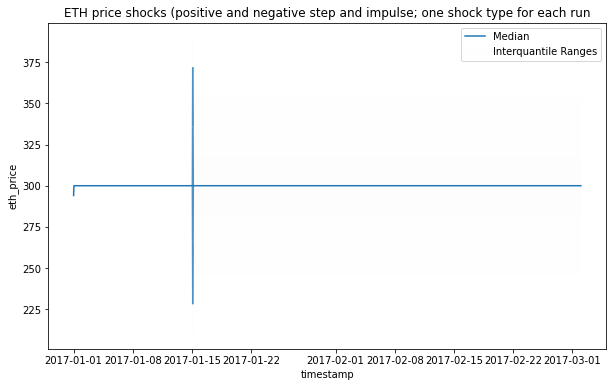

In [17]:
plot_fan_chart(df,'timestamp','timestamp', 'eth_price',lx=False,ly=False,density_hack=True)
plt.title('ETH price shocks (positive and negative step and impulse; one shock type for each run')


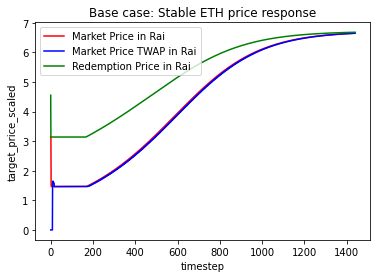

In [18]:
run = df.query('run==1')
sns.lineplot(data=run,x="timestep", y="market_price",color='r',label='Market Price in Rai')
sns.lineplot(data=run,x="timestep", y="market_price_twap",color='b',label='Market Price TWAP in Rai')
sns.lineplot(data=run,x="timestep", y="target_price_scaled",color='g',label='Redemption Price in Rai')
plt.title('Base case: Stable ETH price response')
plt.legend(loc="upper left")


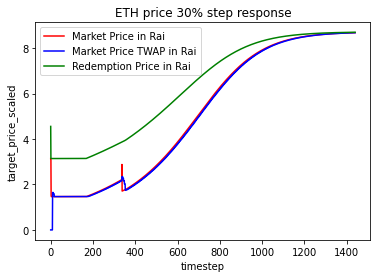

In [19]:
run = df.query('run==2')
sns.lineplot(data=run,x="timestep", y="market_price",color='r',label='Market Price in Rai')
sns.lineplot(data=run,x="timestep", y="market_price_twap",color='b',label='Market Price TWAP in Rai')
sns.lineplot(data=run,x="timestep", y="target_price_scaled",color='g',label='Redemption Price in Rai')
plt.title('ETH price 30% step response')
plt.legend(loc="upper left")



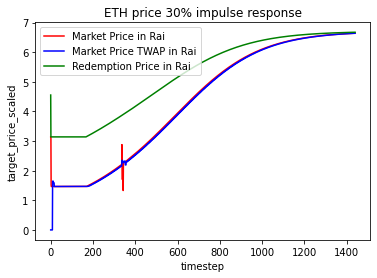

In [20]:
run = df.query('run==3')
sns.lineplot(data=run,x="timestep", y="market_price",color='r',label='Market Price in Rai')
sns.lineplot(data=run,x="timestep", y="market_price_twap",color='b',label='Market Price TWAP in Rai')
sns.lineplot(data=run,x="timestep", y="target_price_scaled",color='g',label='Redemption Price in Rai')
plt.title('ETH price 30% impulse response')
plt.legend(loc="upper left")


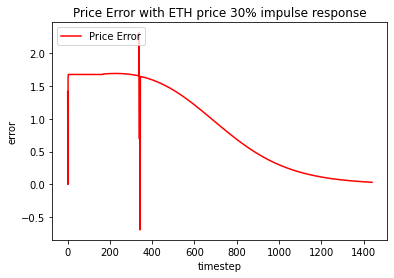

In [31]:
sns.lineplot(data=run,x="timestep", y="error",color='r',label='Price Error')
plt.title('Price Error with ETH price 30% impulse response')
plt.legend(loc="upper left")

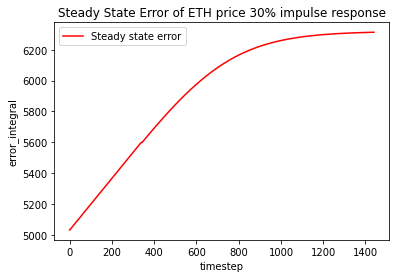

In [30]:
sns.lineplot(data=run,x="timestep", y="error_integral",color='r',label='Steady state error')
plt.title('Steady State Error of ETH price 30% impulse response')
plt.legend(loc="upper left")

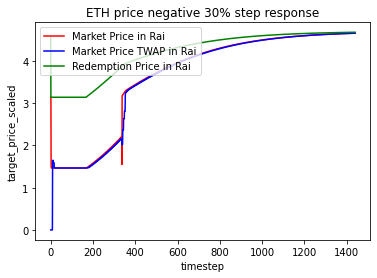

In [23]:
run = df.query('run==4')
sns.lineplot(data=run,x="timestep", y="market_price",color='r',label='Market Price in Rai')
sns.lineplot(data=run,x="timestep", y="market_price_twap",color='b',label='Market Price TWAP in Rai')
sns.lineplot(data=run,x="timestep", y="target_price_scaled",color='g',label='Redemption Price in Rai')
plt.title('ETH price negative 30% step response')
plt.legend(loc="upper left")


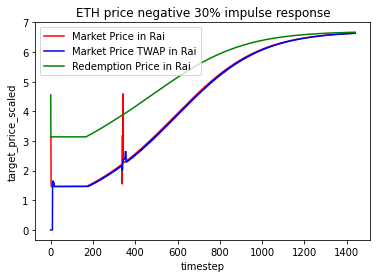

In [24]:
run = df.query('run==5')
sns.lineplot(data=run,x="timestep", y="market_price",color='r',label='Market Price in Rai')
sns.lineplot(data=run,x="timestep", y="market_price_twap",color='b',label='Market Price TWAP in Rai')
sns.lineplot(data=run,x="timestep", y="target_price_scaled",color='g',label='Redemption Price in Rai')
plt.title('ETH price negative 30% impulse response')
plt.legend(loc="upper left")

Text(0.5, 1.0, 'Reflexer principal debt')

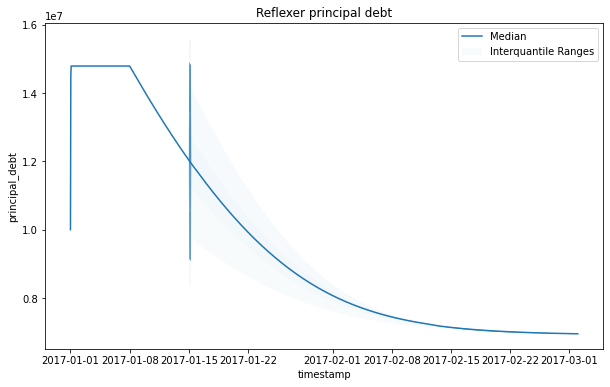

In [25]:
plot_fan_chart(df,'timestamp','timestamp', 'principal_debt',lx=False,ly=False,density_hack=True)
plt.title('Reflexer principal debt')


Text(0.5, 1.0, 'Secondary market RAI balance')

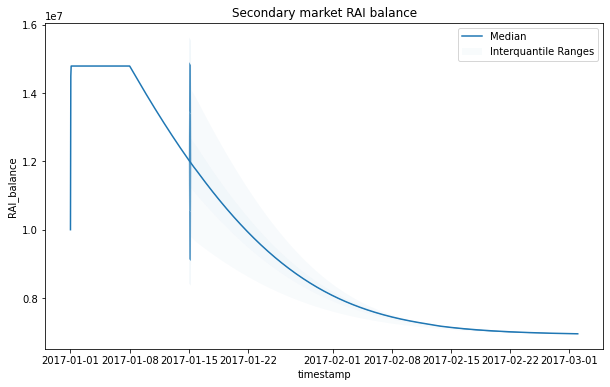

In [26]:
plot_fan_chart(df,'timestamp','timestamp', 'RAI_balance',lx=False,ly=False,density_hack=True)
plt.title('Secondary market RAI balance')


Text(0.5, 1.0, 'Secondary market ETH balance')

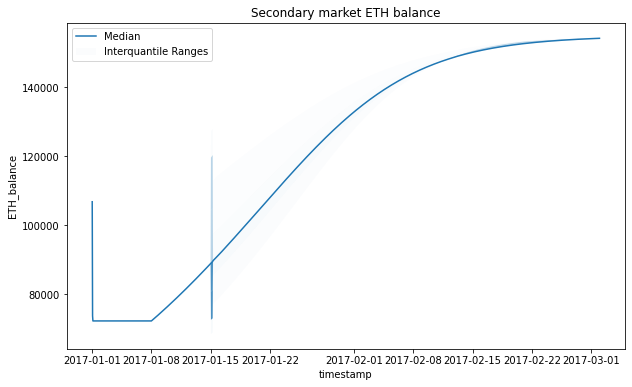

In [28]:
plot_fan_chart(df,'timestamp','timestamp', 'ETH_balance',lx=False,ly=False,density_hack=True)
plt.title('Secondary market ETH balance')


Text(0.5, 1.0, 'Collateralization ratio')

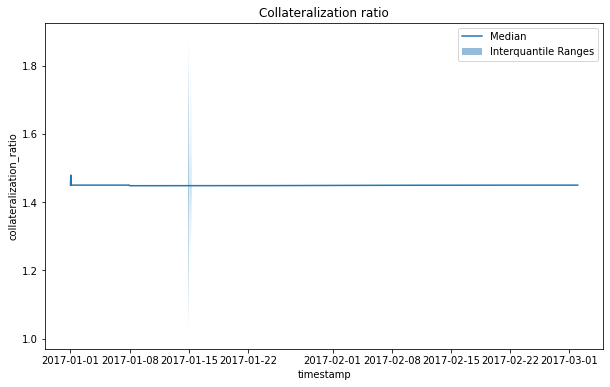

In [29]:
plot_fan_chart(df,'timestamp','timestamp', 'collateralization_ratio',lx=False,ly=False,density_hack=True)
plt.title('Collateralization ratio')


## Conclusion

In this notebook we provided an example of a shock test and the types of plots and analysis that can be performed off of it.